### HVS Data Processing Pipeline
Generating 6D Phase Space for select HVS 

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from astroquery.gaia import Gaia

print("Imported libraries successfully...")

Imported libraries successfully...


In [3]:
# Load CSV into Pandas dataframe
df = pd.read_csv('data/source_data.csv', delimiter=',')
pd.set_option('display.width', 160)
print(df)
print(df.columns)

    HVS            source_id          vhelio          pmra         pmdec          dhelio   pMW  pLMC  log_z_MW
0     1   577294697514301440   831.10 ± 5.70  -0.60 ± 0.60  -0.47 ± 0.39  102.24 ± 14.60  0.72  0.12    -0.490
1     4   699811079173836928   600.90 ± 6.20  -0.20 ± 0.26  -0.60 ± 0.19    63.80 ± 9.70  0.92  0.01    -2.600
2     5  1069326945513133952   545.50 ± 4.30   0.00 ± 0.08  -0.99 ± 0.11    44.20 ± 5.09  0.00  0.00       NaN
3     6  3867267443277880320   609.40 ± 6.80   0.12 ± 0.30   0.12 ± 0.23    55.36 ± 6.88  0.00  0.46     7.000
4     7  3799146650623432704   526.90 ± 3.00  -0.09 ± 0.18   0.02 ± 0.13    52.17 ± 6.25  0.00  0.49    27.000
5     8   633599760258827776   499.30 ± 2.90  -0.88 ± 0.16  -0.28 ± 0.14    53.19 ± 9.80  0.00  0.00   -53.000
6     9  3830584196322129920   616.80 ± 5.10   0.26 ± 0.43  -0.81 ± 0.65   74.10 ± 11.60  0.44  0.77    -0.130
7    10  3926757653770374272   467.90 ± 5.60  -1.09 ± 0.45  -0.99 ± 0.21    51.76 ± 5.72  0.57  0.80    -0.380
8

In [4]:
# Clean columns with +- format, drop unneeded columns (pMW, pLMC, log_z_MW)
# vhelio, pmra, pmdec, dhelio are replaced by val and error columns

cols_to_clean = ['vhelio', 'pmra', 'pmdec', 'dhelio']
for col in cols_to_clean:
    split_data = df[col].str.split(' ± ', expand=True)
    df[f"{col}_val"] = pd.to_numeric(split_data[0])
    df[f"{col}_err"] = pd.to_numeric(split_data[1])

cols_to_drop = ['vhelio', 'pmra', 'pmdec', 'dhelio', 'pMW', 'pLMC', 'log_z_MW']
for col in cols_to_drop:
    df = df.drop(col, axis=1)

print(df)

    HVS            source_id  vhelio_val  vhelio_err  pmra_val  pmra_err  pmdec_val  pmdec_err  dhelio_val  dhelio_err
0     1   577294697514301440       831.1         5.7     -0.60      0.60      -0.47       0.39      102.24       14.60
1     4   699811079173836928       600.9         6.2     -0.20      0.26      -0.60       0.19       63.80        9.70
2     5  1069326945513133952       545.5         4.3      0.00      0.08      -0.99       0.11       44.20        5.09
3     6  3867267443277880320       609.4         6.8      0.12      0.30       0.12       0.23       55.36        6.88
4     7  3799146650623432704       526.9         3.0     -0.09      0.18       0.02       0.13       52.17        6.25
5     8   633599760258827776       499.3         2.9     -0.88      0.16      -0.28       0.14       53.19        9.80
6     9  3830584196322129920       616.8         5.1      0.26      0.43      -0.81       0.65       74.10       11.60
7    10  3926757653770374272       467.9        

In [5]:
# Query DR3 database for RA and Dec values and merge with original dataframe
source_ids = df['source_id'].tolist()

# formats an ADQL query to get values from Gaia DR3
query = f"""
SELECT
    source_id, ra, dec
FROM
    gaiadr3.gaia_source
WHERE
    source_id IN {tuple(source_ids)}
"""
print("Launching job to get results from Gaia database...")
job = Gaia.launch_job_async(query)
gaia_results = job.get_results()

print("Results found. Merging with original database...")
gaia_df = gaia_results.to_pandas()
df = pd.merge(df, gaia_df, on='source_id')
final_column_order = [
    'HVS',
    'source_id',
    'ra',
    'dec',
    'vhelio_val',
    'vhelio_err',
    'pmra_val',
    'pmra_err',
    'pmdec_val',
    'pmdec_err',
    'dhelio_val',
    'dhelio_err'
]
df = df[final_column_order]

print("Dataframe merged. Printing final dataframe...")
print(df)


Launching job to get results from Gaia database...
INFO: Query finished. [astroquery.utils.tap.core]
Results found. Merging with original database...
Dataframe merged. Printing final dataframe...
    HVS            source_id          ra        dec  vhelio_val  vhelio_err  pmra_val  pmra_err  pmdec_val  pmdec_err  dhelio_val  dhelio_err
0     1   577294697514301440  136.937465   2.751909       831.1         5.7     -0.60      0.60      -0.47       0.39      102.24       14.60
1     4   699811079173836928  138.254179  30.855519       600.9         6.2     -0.20      0.26      -0.60       0.19       63.80        9.70
2     5  1069326945513133952  139.497811  67.377323       545.5         4.3      0.00      0.08      -0.99       0.11       44.20        5.09
3     6  3867267443277880320  166.489378   9.577638       609.4         6.8      0.12      0.30       0.12       0.23       55.36        6.88
4     7  3799146650623432704  173.300510   1.140234       526.9         3.0     -0.09      0.1

In [11]:
# Save final dataframe to a CSV.
output_file = '6d_data.csv'
output_dir = 'data'
output_path = os.path.join(output_dir, output_file)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

df.to_csv(output_path, index=False)
print(f"Data saved to '{output_path}'")

Data saved to 'data/6d_data.csv'


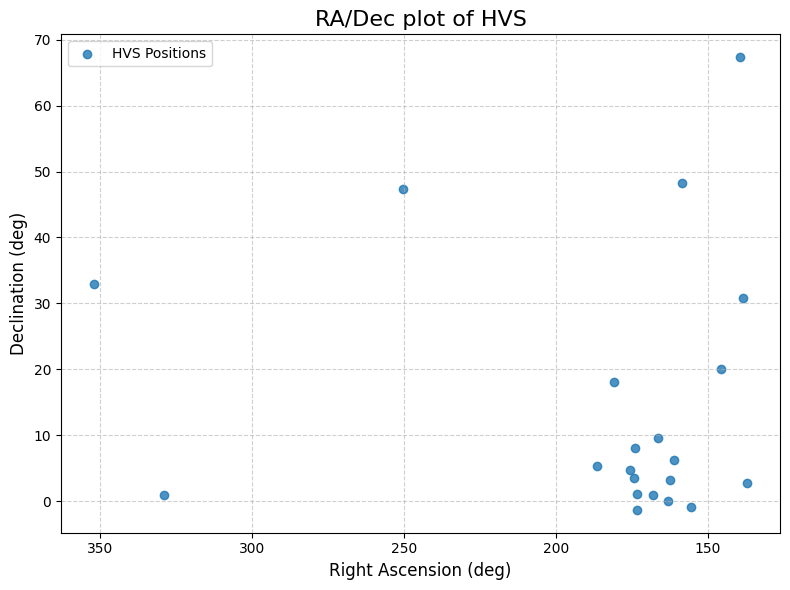

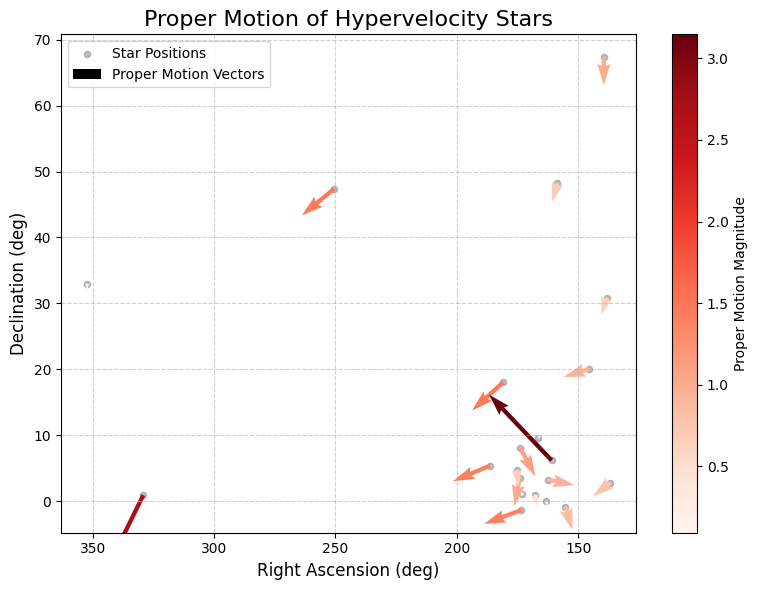

In [20]:
# Basic data visualization on HVS data. Scatter plot and quiver plot
# Scatter plot of RA and Dec
plt.figure(figsize=(8, 6))
plt.scatter(df['ra'], df['dec'], alpha=0.8, label='HVS Positions')
plt.title('RA/Dec plot of HVS', fontsize=16)
plt.xlabel('Right Ascension (deg)', fontsize=12)
plt.ylabel('Declination (deg)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.gca().invert_xaxis()
plt.legend()
plt.tight_layout()

plt.show()

# Quiver plot of proper motions
# Calculate the magnitude (length) of the proper motion vectors
pm_magnitude = np.sqrt(df['pmra_val']**2 + df['pmdec_val']**2)

plt.figure(figsize=(8, 6))
plt.scatter(df['ra'], df['dec'], color='gray', s=20, alpha=0.5, label='Star Positions')

# The color of each arrow is determined by its magnitude via the colormap.
quiver_plot = plt.quiver(df['ra'], df['dec'], df['pmra_val'], df['pmdec_val'],
                         pm_magnitude,
                         cmap='Reds',
                         scale=20,
                         label='Proper Motion Vectors')
                         
plt.title('Proper Motion of Hypervelocity Stars', fontsize=16)
plt.xlabel('Right Ascension (deg)', fontsize=12)
plt.ylabel('Declination (deg)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().invert_xaxis()

plt.colorbar(quiver_plot, label='Proper Motion Magnitude')

plt.legend()
plt.tight_layout()
plt.show()
